For each user, determine her country based on the numeric IP address.

Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

In [112]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
fraud = pd.read_csv('Fraud_Data.csv')
cc    = pd.read_csv('IpAddress_to_Country.csv').sort('upper_bound_ip_address')

## Cleaning

In [ ]:
vals = []
ips = cc['upper_bound_ip_address'].values

for c in fraud.itertuples():
    matches = np.where(ips > c[10])
    if len(matches[0]):
        i = matches[0][0]
        cc1 = cc.loc[i,'country']
        vals.append(cc1)
        if len(vals) % 5000 == 0:
            print len(vals), fraud.shape
    else:
        vals.append(None)

fraud['country'] = vals

In [51]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])

In [52]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [53]:
fraud.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [54]:
fraud.select_dtypes(['object']).describe()

,device_id,source,browser,sex,country
count,151112,151112,151112,151112,131729
unique,137956,3,5,2,181
top,ZUSVMDEZRBDTX,SEO,Chrome,M,United States
freq,20,60615,61432,88293,59283


## Model

In [86]:
fraud['time_to_purchase'] = (fraud['purchase_time'] - fraud['signup_time']).apply(lambda x: x.seconds)
fraud['signup_hr'  ] = fraud['signup_time'].dt.hour
fraud['signup_dow' ] = fraud['signup_time'].dt.dayofweek
fraud['signup_week'] = fraud['signup_time'].dt.week
fraud['purchase_hr'  ] = fraud['purchase_time'].dt.hour
fraud['purchase_dow' ] = fraud['purchase_time'].dt.dayofweek
fraud['purchase_week'] = fraud['purchase_time'].dt.week
fraud['time_since_last'] = ~(
    fraud['purchase_time'] - fraud.groupby('device_id').purchase_time.transform('shift')).apply(
    lambda x: None if pd.isnull(x) else x.seconds).isnull()
fraud['ip_address'] = fraud['ip_address'].astype('string')

fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_to_purchase,signup_hr,signup_dow,signup_week,purchase_hr,purchase_dow,purchase_week,time_since_last
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.8,0,Japan,13882,22,1,9,2,5,16,False
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.866,0,United States,17944,20,6,23,1,0,24,False
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11,1,United States,1,18,3,1,18,3,1,False
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91,0,None,60085,21,1,18,13,0,19,False
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.453,0,United States,41461,7,1,30,18,2,37,False


In [87]:
from sklearn.ensemble import *
from sklearn.preprocessing import *

x = fraud[ fraud.columns[ ~fraud.columns.isin(['user_id', 'signup_time', 'purchase_time', 'class'])] ] # ip_address, device_id
y = fraud['class']


for c in ['source', 'device_id', 'browser', 'sex', 'ip_address', 'country']:
    x[c] = LabelEncoder().fit_transform(x[c])


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [89]:
rf = RandomForestClassifier(min_weight_fraction_leaf=0.01, oob_score=True)
rf.fit(x, y)
rf.oob_score_

0.95396791783577739

## Predictions interpretability

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


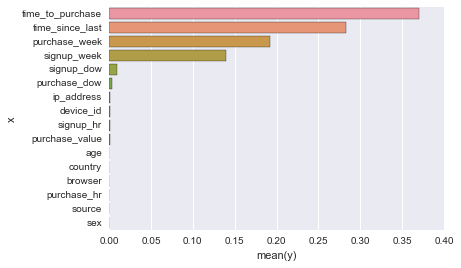

In [101]:
imp = pd.DataFrame(zip(x.columns, rf.feature_importances_), columns=['x', 'y']).sort('y', ascending=False)
sns.barplot(data=imp, x='y', y='x', orient='h'  )

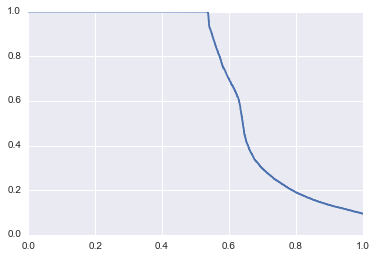

In [113]:
from sklearn.metrics import precision_recall_curve
y_scr = rf.predict_proba(x)
pr, rc, _ = precision_recall_curve(y, y_scr[:, 1])
plt.plot(rc, pr)

the higher the recall, the lower FN
but the higher the FP (lower precision)


In [114]:
x.columns

Index([u'purchase_value', u'device_id', u'source', u'browser', u'sex', u'age',
       u'ip_address', u'country', u'time_to_purchase', u'signup_hr',
       u'signup_dow', u'signup_week', u'purchase_hr', u'purchase_dow',
       u'purchase_week', u'time_since_last'],
      dtype='object')

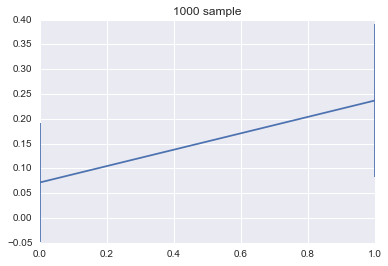

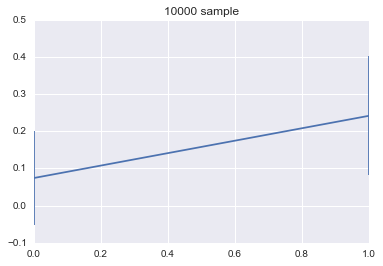

In [139]:
col   = 'time_since_last'
ticks = 100

for k in [1000, 10000]:
    partial    = x.sample(n=k)
    vals = x[col].unique()
#     vmin, vmax = x[col].min(), x[col].max()
#     vals  = np.linspace(vmin, vmax, num=ticks)
    mean  = []
    std   = []
    for v in vals:
        partial[col] = [ v ] * k
        scr = rf.predict_proba(partial)
        mean.append( np.mean(scr[:,1]) )
        std.append(  np.std(scr[:,1]) )
    plt.errorbar(vals, mean, std)
    plt.title("{} sample".format(k))
    plt.show()

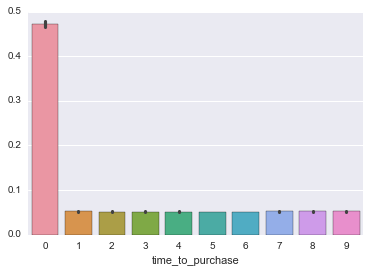

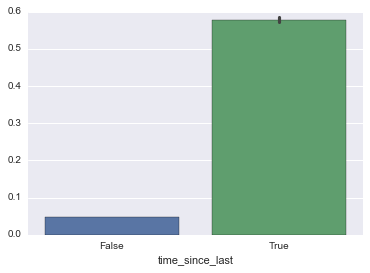

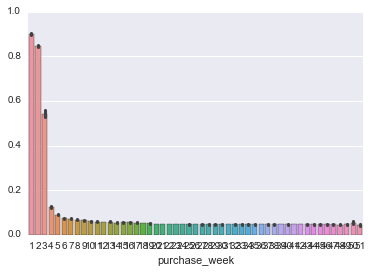

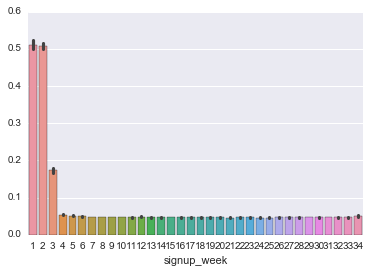

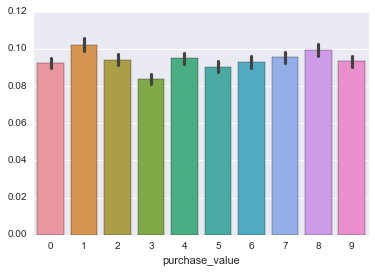

In [129]:
pos = x.copy()
preds = y_scr[:,1]

sns.barplot(x=pd.qcut(x.time_to_purchase, 10, labels=False), y=preds)
plt.show()

sns.barplot(x.time_since_last, y=preds)
plt.show()

sns.barplot(x.purchase_week, y=preds)
plt.show()


sns.barplot(x.signup_week, y=preds)
plt.show()

sns.barplot(x=pd.qcut(x.purchase_value, 10, labels=False), y=preds)
plt.show()
# for c in x.columns:
#     sns.boxplot(x=, y=y_scr[:,1])
#     plt.show()

## Application

ask extra information if is likely to be fraud
asynchronous purchase confirmation 
process every purchase and pu on a queue for approval if fraudulen